## Plane geometry with Julia

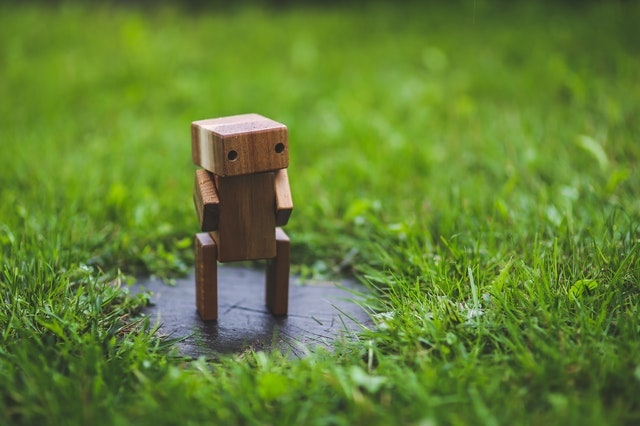

<center>
    Photo by Kaboompics .com from Pexels
</center>

When I first got interested in computer algebra systems, I came across a [book](https://sites.math.rutgers.edu/~zeilberg/GT.html)

    PLANE  GEOMETRY:   AN  ELEMENTARY  TEXTBOOK   
    BY   SHALOSH  B.  EKHAD,  XIV   (CIRCA  2050)   
    DOWNLOADED  FROM  THE  FUTURE   
    BY   DORON  ZEILBERGER

Of course, Shalosh is not really time traveler from a future. He/she/it is the computer of the mathematician [Doron Zeilberger](https://sites.math.rutgers.edu/~zeilberg/), who has been [advocating](https://sites.math.rutgers.edu/~zeilberg/OPINIONS.html) for the use of computers in mathematics for decades. He often write articles and papers with Shalosh named as a coauthor.

The title his book is just a joke.
What Zeilberger really wants to say is that in the future, kids won't need to learn to do (at least) plane geometry with pencil and paper anymore. Their homework will be writing codes so their computer 🤖️ will do the math for them.

The book was written with Maple. But in principle, this can be done in any programming languages. 
With `SymPy.jl` handling the symbolic computation and `Plots.jl` drawing nice pictures, Julia has become a good choice for this task. Writing the code in a modern language also makes things a bit more organized. Moreover, Julia is free but Maple costs 🤑️.

Today I am going to show you how to repeat Zeilberger's [proof](https://sites.math.rutgers.edu/~zeilberg/PG/Napoleon.html) of [Napoleon's theorem](https://en.wikipedia.org/wiki/Napoleon%27s_theorem) using Julia. According to Wikipedia, 
> In geometry, Napoleon's theorem states that if equilateral triangles are constructed on the sides of any triangle, either all outward or all inward, the lines connecting the centres of those equilateral triangles themselves form an equilateral triangle.

## Install needed packages

We will need [`SymPy.jl`](https://github.com/JuliaPy/SymPy.jl) for the computation and `Plot.jl` for some nice plots.

In [ ]:
using Pkg; 
Pkg.activate("."); 
Pkg.add("SymPy")
Pkg.add("Plots")

## Define some geometry objects

In [37]:
struct Point
    x::Number
    y::Number
end

In [38]:
struct Triangle
    A::Point
    B::Point
    C::Point
end

In [39]:
function points(tri::Triangle) 
    [tri.A, tri.B, tri.C]
end;

In [40]:
function edges(tri::Triangle)
    elist = []
    pts = points(tri)
    i = 0
    for i in 1:length(pts)-1
        push!(elist, (pts[i], pts[i+1]))
    end
    push!(elist, (pts[i+1], pts[1]))
    elist
end;

In [41]:
struct Circle
    center::Point
    radius::Number
end

In [42]:
ccenter(c::Circle) = c.center;

## How to draw a triangle

Let's consider the following triangle.

In [43]:
A = Point(0,0); B = Point(1, 3); C = Point(4,2);
tri = Triangle(A, B, C)

Triangle(Point(0, 0), Point(1, 3), Point(4, 2))

To draw it, we create a `Shape` object.

In [44]:
using Plots

In [45]:
function polygonshape(ptlist::Vector{Point})
    xlist = [pt.x for pt in ptlist]
    ylist = [pt.y for pt in ptlist]
    shape = Shape(xlist, ylist)
end;
triangleshape(tri::Triangle) = polygonshape([tri.A, tri.B, tri.C]);

In [46]:
trishape=triangleshape(tri)

Shape([0.0, 1.0, 4.0], [0.0, 3.0, 2.0])

Then we can just fee the shape into `plot()`. The `leg=false` argument hides the unnecessary plot legend.

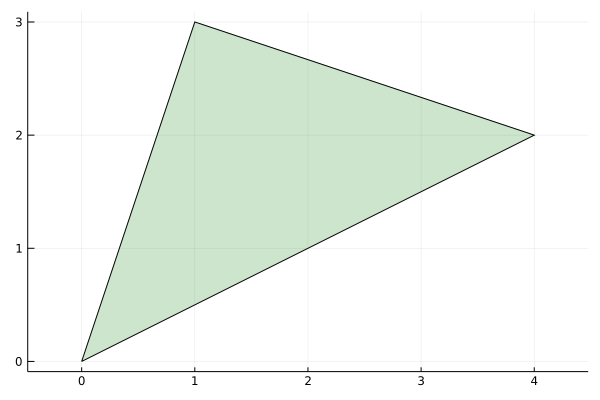

In [47]:
plot(trishape, leg=false, fill=(0, :green), aspect_ratio=:equal, fillalpha= 0.2)

Let's point out where are the 3 points $A$, $B$ and $C$.

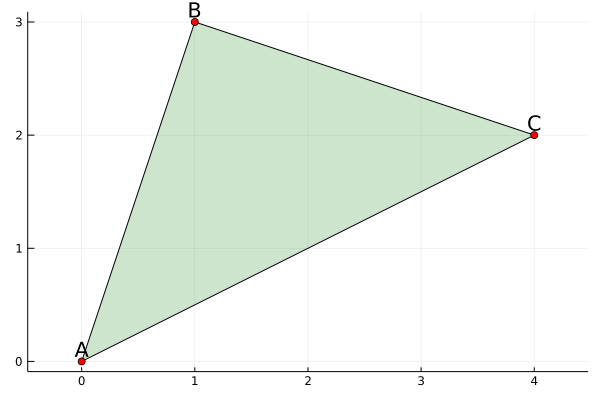

In [48]:
scatter!(trishape.x, trishape.y, color=:red, series_annotations = text.(["A", "B", "C"], :bottom))

## Equilateral triangles

There are two points that are can form a equilateral triangle with $A$ and $B$. Let's find them.

First we define a functions that computes the squared euclidean distance between two points.

In [49]:
function squaredist(A, B)
    (A.x-B.x)^2+(A.y-B.y)^2
end;

We need to solve a quadratic equation. For this we use `SymPy.jl`

In [50]:
using SymPy

function equipoints(A, B)
    x, y = @vars x y
    pt = Point(x, y)
    dist1 = squaredist(pt, A)
    dist2 = squaredist(pt, B)
    dist3 = squaredist(A, B)
    sol = solve([dist1-dist3, dist2-dist3], [x,y])
    [Point(s[1], s[2]) for s in sol]
end;

These are the two points that can form equilateral triangles with $A$ and $B$.

In [51]:
ptAB = equipoints(A, B)

2-element Array{Point,1}:
 Point(1/2 - 3*sqrt(3)/2, sqrt(3)/2 + 3/2)
 Point(1/2 + 3*sqrt(3)/2, 3/2 - sqrt(3)/2)

Let's consider only the outer equilateral triangle. So among the two points we only keep the one that is closer to $C$. The following function does that for us.

In [52]:
function outer_eqitri(A, B, C)
    ptAB = equipoints(A, B)
    dist = map(pt->squaredist(pt, C), ptAB)
    if dist[1] >= dist[2]
        return Triangle(A, B, ptAB[1])
    else
        return Triangle(A, B, ptAB[2])
    end
end;

And we write function to do this for all the three edges of $\Delta ABC$.

In [53]:
function outer_triangles(tri)
    pts = points(tri)
    map(i->outer_eqitri(circshift(pts, i)...), 0:2)
end

outer_triangles (generic function with 1 method)

These are the three outer equilateral triangles for $\Delta ABC$.

In [54]:
outer_tri = outer_triangles(tri)

3-element Array{Triangle,1}:
 Triangle(Point(0, 0), Point(1, 3), Point(1/2 - 3*sqrt(3)/2, sqrt(3)/2 + 3/2))
 Triangle(Point(4, 2), Point(0, 0), Point(sqrt(3) + 2, 1 - 2*sqrt(3)))
 Triangle(Point(1, 3), Point(4, 2), Point(sqrt(3)/2 + 5/2, 5/2 + 3*sqrt(3)/2))

Let's draw these three triangles to see if we get it correctly.

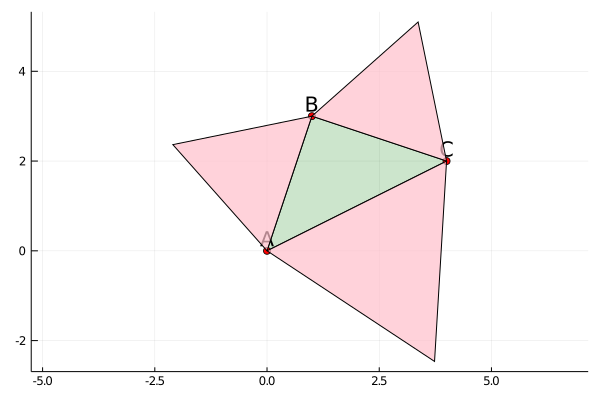

In [55]:
for t in outer_tri
    plot!(triangleshape(t), leg=false, fill=(0, :pink), fillalpha=0.7)
end
current()  # Show the current plot

Looks fine!

## Circumcenter

Now we can compute the [orthocenter](https://en.wikipedia.org/wiki/Altitude_(triangle)#Orthocenter) of the three triangles.

First a function that computes the circle that goes through several points.

In [56]:
function circumcircle(points)
    x, y = @vars x y
    c = Point(x, y)
    dist = [squaredist(pt, c) for pt in points]
    equations = [Eq(dist[i], dist[i+1]) for i in 1:length(points)-1]
    sol = solve(equations, [x, y])
    center = Point(simplify(sol[x]), simplify(sol[y]))
    Circle(center, sqrt(squaredist(center, points[1])))
end;

So the circumcircles of the three outer equilateral triangles are

In [57]:
outer_circles = circumcircle.(points.(outer_tri))

3-element Array{Circle,1}:
 Circle(Point(1/2 - sqrt(3)/2, sqrt(3)/6 + 3/2), sqrt((1/2 - sqrt(3)/2)^2 + (sqrt(3)/6 + 3/2)^2))
 Circle(Point(sqrt(3)/3 + 2, 1 - 2*sqrt(3)/3), sqrt((-2 + sqrt(3)/3)^2 + (-2*sqrt(3)/3 - 1)^2))
 Circle(Point(sqrt(3)/6 + 5/2, sqrt(3)/2 + 5/2), sqrt((-1/2 + sqrt(3)/2)^2 + (sqrt(3)/6 + 3/2)^2))

Let's again draw them to see if we computed them correctly.

In [58]:
function circleshape(x, y, r)
    θ = LinRange(0, 2*π, 300)
    x .+ r*sin.(θ), y .+ r*cos.(θ)
end;
circleshape(pt::Point, r) = circleshape(pt.x, pt.y, r);
circleshape(circle::Circle) = circleshape(circle.center, circle.radius);

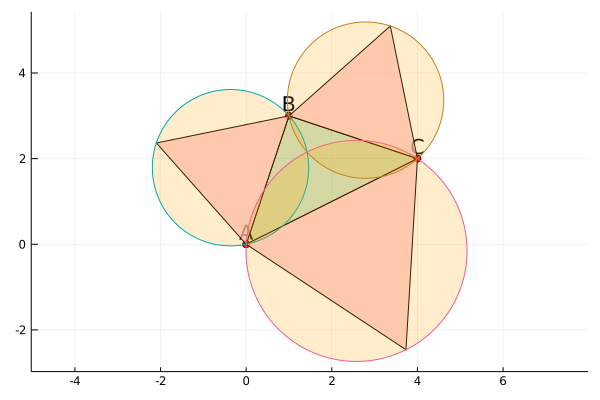

In [59]:
for c in outer_circles
    plot!(circleshape(c), leg=false, fill=(0, :orange), aspect_ratio=:equal, fillalpha=0.2)
end
current() # Show current plot

Now let's draw the triangle formed by the center of these 3 circles.

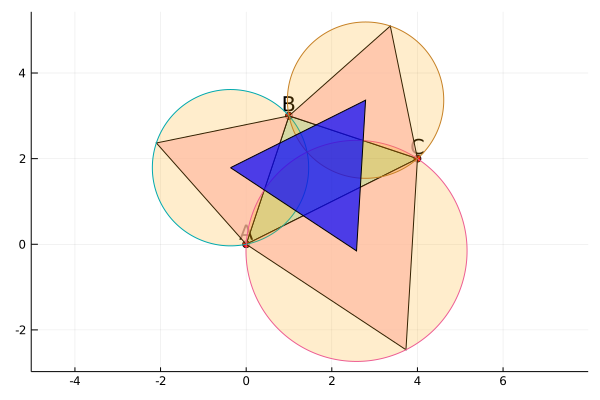

In [60]:
outer_centers = ccenter.(outer_circles);
napolean_tri = Triangle(outer_centers...);
plot!(triangleshape(napolean_tri), leg=false, fill=(0, :blue), fillalpha=0.7, aspect_ratio=:equal)

According to the theorem, this blue triangle is actually equilateral? Is it? A function to check it --

In [61]:
function isequilateral(tri)
    dist = [e->squaredist(e[1], e[2]) for e in edges(tri)]
    if dist[1] == dist[2] == dist[3]
        return true
    else
        return false
    end
end;

In [62]:
isequilateral(napolean_tri)

true

So the theorem is at least correct in this example. 😀️

## A coincidence?

Maybe we are just lucky and choose a triangle that the theorem holds. To be sure, we can try some more triangles. 

First we put how we draw the picture above in a function.

In [63]:
function draw_napoleon(xA, yA, xB, yB, xC, yC)
    A = Point(xA, yA); 
    B = Point(xB, yB); 
    C = Point(xC, yC);
    tri = Triangle(A, B, C)
    trishape=triangleshape(tri)
    plot(trishape, leg=false, fill=(0, :green), aspect_ratio=:equal, fillalpha= 0.2)
    scatter!(trishape.x, trishape.y, color=:red, series_annotations = text.(["A", "B", "C"], :bottom))
    outer_tri = outer_triangles(tri)
    for t in outer_tri
        plot!(triangleshape(t), leg=false, fill=(0, :pink), aspect_ratio=:equal, fillalpha=0.7)
    end
    outer_circles = circumcircle.(points.(outer_tri))
    outer_centers = ccenter.(outer_circles);
    napolean_tri = Triangle(outer_centers...);
    p = plot!(triangleshape(napolean_tri), leg=false, fill=(0, :blue), fillalpha=0.7, aspect_ratio=:equal)
    p, isequilateral(napolean_tri)
end;

Let's pick a random triangle.

In [64]:
function rand_nappleon()
    pts = rand(0:1//10:1,6);
    plt, ret = draw_napoleon(pts...)
    if(ret == true)
        println("Theorem holds! 😀️")
    else
        println("Theorem holds! 😱️")
    end
    plt
end;

Theorem holds! 😀️


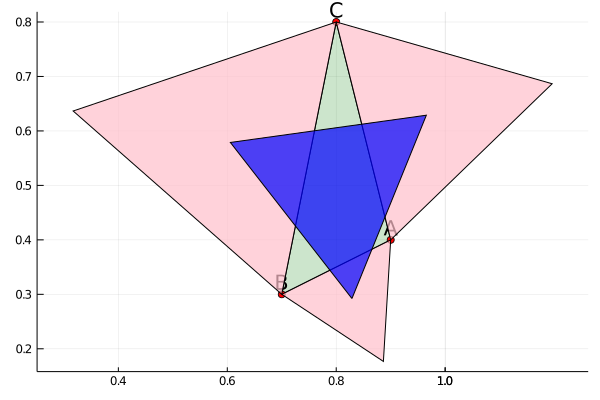

In [65]:
rand_nappleon()

Let's try again.

Theorem holds! 😀️


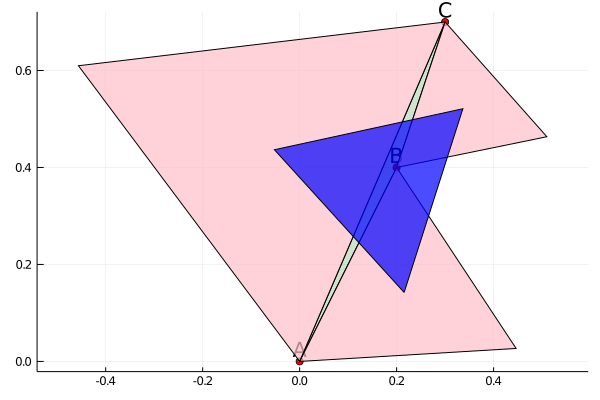

In [66]:
rand_nappleon()

## A symbolic proof

Of course, examples are not proofs. But what are proofs? Often a proof is just a computation done with symbols instead of fixed numbers.

Note that symbols, e.g., $x$, is different from Julia's variables. It does not hold any value but is just a placeholder in a computation. This means if a symbolic computation with $x$ is valid, then then the computation still holds if we replace $x$ with *any* number.

First, note that we can assume that $A = (0,0)$, $B$ is on the positive half of $y$-axis, and $C$ is in the right half of the plane. In other words, something like this.

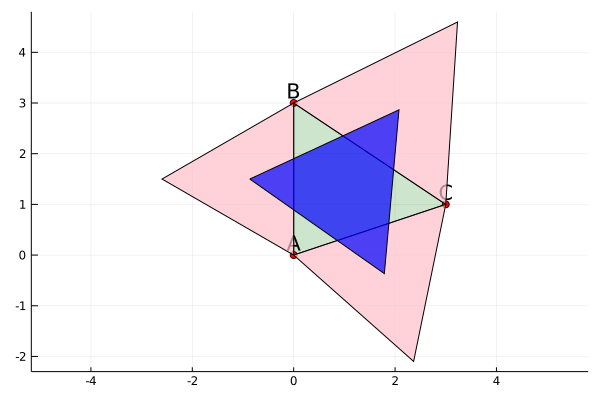

In [67]:
plt, ret = draw_napoleon(0, 0, 0, 3, 3, 1)
plt

We can always move a triangle so it satisfies these conditions.

Let represent their coordinates by symbols. 

In [68]:
@vars by cx positive=true;
@vars cy;

In [69]:
A = Point(0, 0); B = Point(0, by); C = Point(cx, cy);
tri = Triangle(A, B, C)

Triangle(Point(0, 0), Point(0, by), Point(cx, cy))

All the computations done before, we can just copy and paste!

In [70]:
outer_tri = outer_triangles(tri);
outer_circles = circumcircle.(points.(outer_tri));
outer_centers = ccenter.(outer_circles);
napolean_tri = Triangle(outer_centers...)
isequilateral(napolean_tri)

true

So, Napoleon is right! 😀️ But do you think future kids will actually prove this theorem like this in class? 🤔️